In [2]:
%%capture
!pip install transformers==4.31
!pip install accelerate 
!pip install opencv-python

In [2]:
import torch

from PIL import Image
import pickle
import numpy as np
import cv2
from matplotlib import pyplot as plt

from lavis.models import load_model_and_preprocess

/opt/conda/envs/pytorch/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [3]:
model, vis_preprocess, txt_preprocess = load_model_and_preprocess("blip_diffusion", "base", device="cuda", is_eval=True)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


No ctx_embeddings_cache found in /home/ubuntu/.cache/torch/hub/checkpoints/blip-diffusion


In [4]:
!ls images

dog_2.jpg  dog_and_cat.jpg  rope.jpg  sofa.jpg


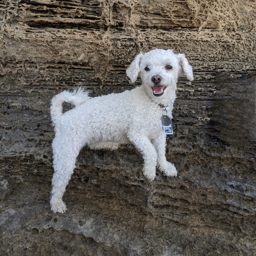

In [21]:
cond_subject = "dog"
src_subject = "soda"
tgt_subject = "dog"

text_prompt = "on blank space"

src_subject = txt_preprocess["eval"](src_subject)
tgt_subject = txt_preprocess["eval"](tgt_subject)
cond_subject = txt_preprocess["eval"](cond_subject)
text_prompt = [txt_preprocess["eval"](text_prompt)]

cond_image = Image.open("images/dog_2.jpg").convert("RGB")
display(cond_image.resize((256, 256)))
cond_image = vis_preprocess["eval"](cond_image).unsqueeze(0).cuda()

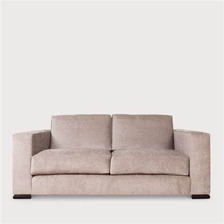

In [22]:
src_image = Image.open("images/sofa.jpg").convert("RGB")
display(src_image.resize((224, 224)))

In [23]:
samples = {
    "cond_images": cond_image,
    "cond_subject": cond_subject,
    "src_subject": src_subject,
    "tgt_subject": tgt_subject,
    "prompt": text_prompt,
    "raw_image": src_image,
}

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.56it/s]


['a soda on blank space', 'a sks sks sks sks sks sks sks sks sks sks sks sks sks sks sks sks dog on blank space']


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.44it/s]


Before editing:


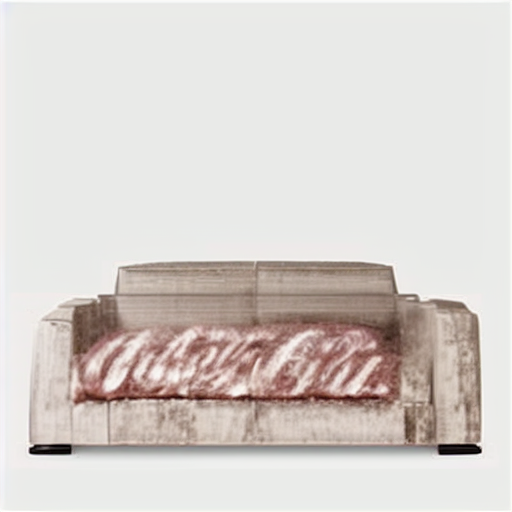

After editing:


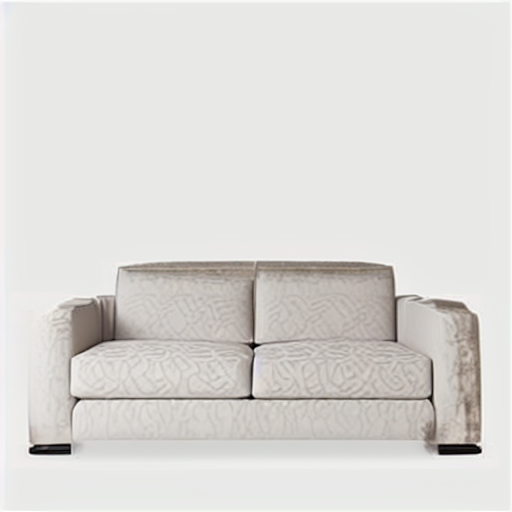

In [24]:
iter_seed = 88871
guidance_scale = 7.5
num_inference_steps = 50
num_inversion_steps = 50 # increase to improve DDIM inversion quality
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

output = model.edit(
    samples,
    seed=iter_seed,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    num_inversion_steps=num_inversion_steps,
    neg_prompt=negative_prompt,
)

print("=" * 30)
print("Before editing:")
display(output[0])

print("After editing:")
display(output[1])

In [12]:
with open("/home/ubuntu/LAVIS_BLIP/masks/mask_1", 'rb') as f:
    masks = pickle.load(f)

In [13]:
len(masks)

1

In [14]:
masks[0].size()

torch.Size([1, 1, 64, 64])

In [6]:
mask = masks[0].squeeze().cpu()

In [7]:
np_mask = mask.numpy()

In [41]:
norm_mask = np_mask / np_mask.max()

In [43]:
cond_image_raw = Image.open("images/rope.jpg").convert("RGB")

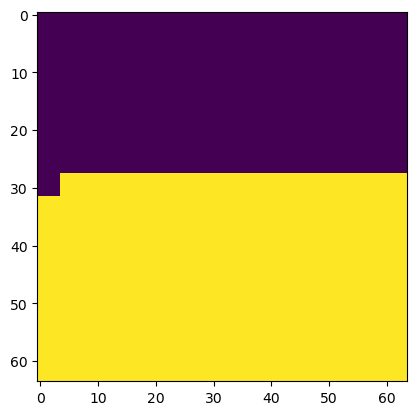

In [44]:
plt.imshow(norm_mask)

In [45]:
kernel = np.ones((3, 3),np.uint8)

In [46]:
dilation = cv2.dilate(norm_mask,kernel,iterations = 1)

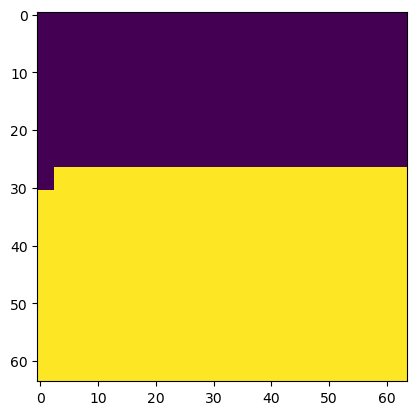

In [47]:
plt.imshow(dilation)